<a href="https://colab.research.google.com/github/sebastianmunozvasq/Portfolio-SMV/blob/Boundary-value-problems/Fixed_point_iteration_convective_and_radiative_cooling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fixed-point iteration for solving problems at boundary values: convective and radiative cooling



### 1. Description of the physical system

You have a circular pipe in which a hot fluid flows. The pipe has length $L$ and internal diameter $d_i$. Assumptions to consider:

- The outer diameter of the pipe is approximately equal to the inner diameter, $d_o = d_i$, since the pipe wall is very thin.
- The velocity profile of the fluid flow inside the pipe is described by piston flow with velocity $v_0$.
- The density and heat capacity of the fluid do not change considerably with temperature.
- The fluid is incompressible, therefore $\hat{c}_p \approx \hat{c}_v$.
- The fluid and the pipe wall are in thermal equilibrium at all positions.
- The absorptance ($a$) and emissivity ($\epsilon$) of the pipe wall are assumed equal.

#### 1.1 Energy Balance - Steady State Temperature Profile
The ordinary differential equation (ODE) describing the steady state pipe temperature profile subject to heat loss by natural convection and radiation is:

$$\alpha\frac{d^2 T}{d x^2} = v_0\frac{d T}{d x} + \frac{4 h}{d_i \rho \hat{c}_p}(T-T_{aire}) +\frac{4\varepsilon\sigma}{d_i \rho \hat{c}_p} (T^4-T_{aire}^4)$$

With boundary conditions:

$$ T|_{x=0} = T_{in}$$

$$\frac{d T}{d x}|_{x=L} = 0$$

This ODE together with its boundary conditions is a nonlinear mathematical problem with no known analytical solution. Therefore we require numerical methods to find the temperature profile along the pipe.

#### 1.2 Discretization of the problem to the boundary values
We discretize this ODE using the finite difference method to approximate the derivatives and obtain a system of nonlinear algebraic equations. We consider a grid in the $x$ coordinate such that at each internal point of the pipe there is a temperature $T_i$. The temperature of the node on the left or upstream is T_{i-1}, and the temperature of the node on the right or downstream is T_{i+1}. Using a second-order central scheme for the second and first derivatives in $x$, we obtain:

$$\alpha\frac{T_{i+1} - 2 T_i + T_{i-1}}{\Delta x^2} = v_0\frac{T_{i+1} - T_{i-1}}{2\Delta x} + \frac{4 h}{d_i \rho \hat{c}_p}(T_i - T_{aire}) +\frac{4\varepsilon\sigma}{d_i \rho \hat{c}_p} (T_i^4 - T_{aire}^4)$$

We group the factors multiplying the temperature at the three adjacent nodes $T_{i-1}$, $T_i$ and $T_{i+1}$ on the left side, and the independent terms of the temperature of the nodes on the right side:

$$\left(\frac{\alpha}{\Delta x^2}+\frac{v_0}{2\Delta x}\right)T_{i-1} + \left(-\frac{2\alpha}{\Delta x^2} - \frac{4 h}{d_i \rho \hat{c}_p} - \frac{4\varepsilon\sigma T_i^3}{d_i \rho \hat{c}_p}\right)T_i + \left(\frac{\alpha}{\Delta x^2}-\frac{v_0}{2\Delta x}\right)T_{i+1} = -\frac{4 h}{d_i \rho \hat{c}_p}T_{aire} -\frac{4\varepsilon\sigma}{d_i \rho \hat{c}_p} T_{aire}^4$$

We discretize the boundary conditions. At $x=0$, the discretization of the boundary condition is Dirichlet and its discretization is direct:

$$T_1 = T_{in}$$

and at $x=L$, the boundary condition is homogeneous Neumann. Using second order backward finite differences for the first derivative, we obtain:

$$T_{N-2} - 4T_{N-1} +3T_{N} = 0$$

The discretized ODE together with the discretized boundary conditions constitute a system of nonlinear equations.

#### 2.1 Matrix form of system of nonlinear equations

We can express the discretized problem at the boundary values in matrix form by rewriting it as follows:

$$ A\mathbf{T} = \mathbf{b} + \mathbf{f}(\mathbf{T})$$

With the right-hand side vector $\mathbf{b}$ only containing constant values and the right-hand side vector $\mathbf{f}$ containing a nonlinear function of the temperature $f(T)$.

To better visualize the problem, we use the following definitions: $k_1=\frac{4 h}{d_i \rho \hat{c}_p}$, $k_2=\frac{4\varepsilon\sigma}{d_i \rho \hat{c}_p}$, $a_1=\frac{\alpha}{\Delta x^2}$ y $a_2=\frac{v_0}{2\Delta x}$.

<font size="3">
$\begin{bmatrix}
  1 & 0 & 0 & 0 & 0 & 0\\
  a_1+a_2 & -2a_1 -k_1 & a_1-a_2 & 0 & 0 & 0\\
  0 & a_1+a_2 & -2a_1 -k_1& a_1-a_2 & 0 & 0\\
  0 & 0 & \ddots &\ddots & \ddots & 0\\
  0 & 0 & 0 & a_1+a_2 & -2a_1 -k_1 & a_1-a_2\\
  0 & 0 & 0 & 1 & -4 & 3
\end{bmatrix}
\begin{bmatrix}
  T_1\\
  T_2\\
  \vdots\\
  \vdots\\
  T_i\\
  \vdots\\
  \vdots\\
  T_{N-1}\\
  T_{N}
\end{bmatrix}
{=}
\begin{bmatrix}
  T_{in}\\
  - k_1 T_{aire}\\
  - k_1 T_{aire}\\
  \vdots\\
  \vdots\\
  - k_1 T_{aire}\\
  0
\end{bmatrix}
+
\begin{bmatrix}
  0\\
  k_2(T_2^4 - T_{aire}^4)\\
  k_2(T_3^4 - T_{aire}^4)\\
  \vdots\\
  \vdots\\
  k_2(T_{N-1}^4 - T_{aire}^4)\\
  0
\end{bmatrix}$
</font>

We will use this matrix form for the implementation of the fixed-point iteration method.

#### Import modules

In [ ]:
# Improve plot quality in Jupyter Notebook
# %matplotlib notebook

# Data visualization and plotting
import matplotlib.pyplot as plt

# Numerical computing
import numpy as np

# Function for numerical integration
from scipy.integrate import solve_ivp


#### Initialize problem variables and parameters

In [ ]:
# Known constant parameters

# Length of the pipe / m
L = 100

# Internal diameter of the pipe / m
di = 0.0254 * 2

# Fluid velocity / m s^-1
v0 = 1e-2

# Fluid density / kg m^-3
rho = 950

# Thermal conductivity / W m^-1 K^-1
k = 0.05

# Natural convection heat transfer coefficient / W m^-2 K^-1
h = 10

# Specific heat capacity at constant pressure / J kg^-1 K^-1
cp = 3800

# Thermal diffusivity / m^2 s^-1
alpha = 1.16e-7

# Emissivity of the tank wall material (dimensionless)
em = 0.9

# Stefan-Boltzmann constant / W m^-2 K^-4
sigma = 5.670374419e-8

# Ambient air temperature / K
Taire = 273 + 18

# Fluid inlet temperature / K
Tin = 273 + 90


#### 2.2: Generate the vector with the specific points at the $x$ coordinate where the solution is desired

We define a vector in the space that defines our one-dimensional mesh at coordinate $x$ and the initial temperature values along $x$.

In [ ]:
# Grid in the x-coordinate along the pipe

# Define a tuple of two elements containing the initial and final values of x
x_range = (0.0, L)

# Define the number of desired points for our grid
N = 101

# Define a vector in the x space where the solution will be evaluated
dx = L / (N - 1)
x_grid = np.linspace(0.0, L, N)

# Print the step size and the grid
print(dx)
print(x_grid)


1.0
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100.]


##### 2.3: Fixed-point functional iteration to solve the problem at the boundary values

We use the matrix form of the problem at the boundary values that we defined previously:

$$ A\mathbf{T} = \mathbf{b} + \mathbf{f}(\mathbf{T})$$

$A$: coefficient matrix grouping all terms that are linear in the temperatures at the grid nodes.

$\mathbf{T}$: vector of unknowns for the temperatures.

$\mathbf{b}$: vector of the right-hand side resulting from the boundary conditions and constant values of the right-hand side of the system of equations.

$\mathbf{f}$: right-hand side vector containing function $f(T)$ evaluated at the grid temperatures, with first and last elements equal to zero.

The fixed-point iteration sequence is:

$$\mathbf{T}^{(0)} = A^{-1}\mathbf{b}$$
$$\mathbf{T}^{(1)} = A^{-1}(\mathbf{b} + \mathbf{f}(\mathbf{T}^{(0)}))$$
$$\mathbf{T}^{(2)} = A^{-1}(\mathbf{b} + \mathbf{f}(\mathbf{T}^{(1)}))$$
$$\ldots$$
$$\mathbf{T}^{(j+1)} = A^{-1}(\mathbf{b} + \mathbf{f}(\mathbf{T}^{(j)}))$$

Where $j = 0,1,2,\ldots$ is the counter in our iteration algorithm.

#### 2.4 Definition of the linear subsystem

In [ ]:
# Define the constant parameters to be used in the matrix A

# Natural convection parameter
k1 = 4 * h / (di * rho * cp)

# Radiation parameter
k2 = 4 * em * sigma / (di * rho * cp)

# Conduction parameter
r1 = alpha / (dx**2)

# Convection parameter
r2 = v0 / (2 * dx)


Construction of coefficient matrix **A**

In [ ]:
# Construct matrix A
A = np.zeros([N, N])

# First row
A[0][0] = 1

# Rows 2 to N-1

# Start from 1 to avoid assigning the first row
# Go up to N-1 to avoid assigning the last row
for i in range(1, N-1):

    # First "moving column" of row i
    A[i][i-1] = r1 + r2

    # Second "moving column" of row i
    A[i][i] = -2 * r1 - k1

    # Third "moving column" of row i
    A[i][i+1] = r1 - r2

# Last row
A[-1][-3] = 1
A[-1][-2] = -4
A[-1][-1] = 3


Construction of the right-hand side vector **b**

In [ ]:
# Construct the right-hand side vector b
b = np.zeros(N)

# First element
b[0] = Tin

# Central elements from 1 to N-2
for i in range(1, N-1):
    b[i] = -k1 * Taire

# Last element
b[-1] = 0

# print(b)


### 3 Fixed point method for functional iteration - (key)

In [ ]:
# Initialize zero vector for the right-hand side vector f
f = np.zeros(N)


In [ ]:
# Define variables for functional iteration

# Solution to the problem when there is only natural convection cooling and no radiation
Tconv = np.linalg.solve(A, b)

# Initial temperature vector, initial estimate
T0 = Tconv

# print(T0)

# Initialize counter
j = 0

# Define maximum number of iterations
jmax = 1000

# Initialize error
err = 1

# Define tolerance
tol = 1e-6


In [ ]:
# Functional iteration
print('j error')
while err > tol and j < jmax:

    # Construct the right-hand side vector f
    for i in range(1, N-1):
        f[i] = k2 * (T0[i]**4 - Taire**4)

    # Solve the matrix system A*T = b + f
    tmp = b + f
    T = np.linalg.solve(A, tmp)

    # Calculate new error
    err = np.linalg.norm(T - T0)
    print(j, err)

    # Increment counter
    j = j + 1

    # Update temperature estimate vector
    T0 = T


j error
0 138.47847419742246
1 56.59290261575397
2 18.06638538295006
3 4.889548003776925
4 1.1087007380521647
5 0.21711013856055486
6 0.03763338440522681
7 0.006370159186621432
8 0.0014494969442484574
9 0.000509682024683232
10 0.00019865556816733734
11 7.32525442136222e-05
12 2.4814539544974094e-05
13 7.724241374073934e-06
14 2.225025773328224e-06
15 5.987884841434717e-07


### Step 4: Visualize solution

We visualize the solutions to the cases together for cooling by: convection and radiation and convection only.

Cooling of the fluid occurs predominantly by natural convection and the temperature decreases non-linearly until thermal equilibrium with the surroundings is reached. Therefore the temperature of the system at a sufficiently long distance approaches $T_{air}$.

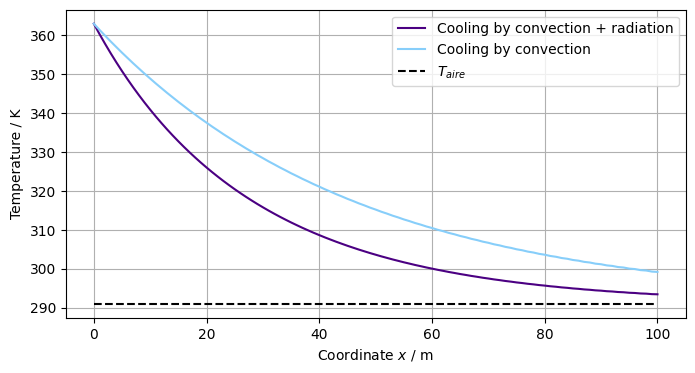

In [ ]:
fig = plt.subplots(figsize=[8,4])

plt.plot(x_grid, T, color='indigo', label='Cooling by convection + radiation')
plt.plot(x_grid, Tconv, 'lightskyblue', label='Cooling by convection')
plt.plot(x_grid, x_grid*0 + Taire, 'k--', label='$T_{aire}$')

plt.grid()
plt.legend(fontsize=10)
plt.tick_params(labelsize=10)
plt.xlabel('Coordinate $x$ / m')
plt.ylabel('Temperature / K')

plt.show()


#### Step 5: Verification of convergence to solution by convection cooling alone when the effect of radiation decreases

In [ ]:
# Define variables for fixed-point iteration
# Initial temperature vector, initial guess
T01 = Tconv
T02 = Tconv

# Initialize counters
j1 = 0
j2 = 0

# Initialize errors
err1 = 1
err2 = 1

# Define parameter to modify radiant effect
beta1 = 0.5
beta2 = 0.2


In [ ]:
# Initialize zero vectors for the right-hand side vectors f
fprime1 = np.zeros(N)
fprime2 = np.zeros(N)


In [ ]:
# Fixed-point iteration with beta = 0.5

while err1 > tol and j1 < jmax:

    # Construct the right-hand side vector f
    for i in range(1, N-1):
        fprime1[i] = beta1 * k2 * (T01[i]**4 - Taire**4)

    # Solve the matrix system AT = b + f
    tmp1 = b + fprime1
    Tprime1 = np.linalg.solve(A, tmp1)

    # Calculate new error
    err1 = np.linalg.norm(Tprime1 - T01)

    # Increment counter
    j1 += 1

    # Update temperature estimate vector
    T01 = Tprime1


In [ ]:
# Fixed-point iteration with beta = 0.2
while err2 > tol and j2 < jmax:

    # Construct the right-hand side vector f
    for i in range(1, N-1):
        fprime2[i] = beta2 * k2 * (T02[i]**4 - Taire**4)

    # Solve the matrix system AT = b + f
    tmp2 = b + fprime2
    Tprime2 = np.linalg.solve(A, tmp2)

    # Calculate new error
    err2 = np.linalg.norm(Tprime2 - T02)

    # Increment counter
    j2 += 1

    # Update temperature estimate vector
    T02 = Tprime2


#### Four-case graph:

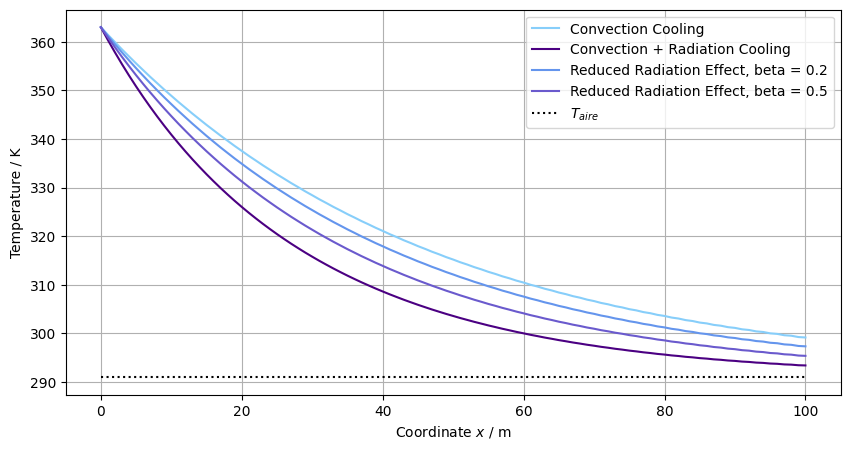

In [ ]:
# Create a figure with a specific size
fig = plt.subplots(figsize=[10,5])

# Plot the temperature with convection cooling
plt.plot(x_grid, Tconv, 'lightskyblue', label='Convection Cooling')

# Plot the temperature with convection and radiation cooling
plt.plot(x_grid, T, color='indigo', label='Convection + Radiation Cooling')

# Plot the temperature with reduced radiation effect (beta = 0.2)
plt.plot(x_grid, Tprime2, 'cornflowerblue', label='Reduced Radiation Effect, beta = 0.2')

# Plot the temperature with reduced radiation effect (beta = 0.5)
plt.plot(x_grid, Tprime1, 'slateblue', label='Reduced Radiation Effect, beta = 0.5')

# Plot the air temperature
plt.plot(x_grid, x_grid*0 + Taire, 'k:', label='$T_{aire}$')

# Add a grid to the plot
plt.grid()

# Add a legend with a specific font size
plt.legend(fontsize=10)

# Set the font size of the axis labels
plt.tick_params(labelsize=10)

# Add labels to the x and y axes
plt.xlabel('Coordinate $x$ / m')
plt.ylabel('Temperature / K')

# Show the plot
plt.show()
